In [ ]:
import os
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time
from google.colab import drive

%load_ext tensorboard
drive.mount('/content/drive')

# classNames = ['Brassica', 'Calendula', 'Cardus', 'Castanea', 'Cistus_sp', 'Citrus_sp', 'Hedysarum', 'Helianthus_annuus', 'Lotus', 'Quercus_sp']

data_dir = '/content/drive/MyDrive/train/'
filepaths = []
class_labels = []
file_list = os.listdir(data_dir)
for file in file_list:
    file_path = os.path.join(data_dir,file)
    filepaths.append(file_path)
    label = file.split('_')[0]
    label = label.replace(' ', '_')
    class_labels.append(label)

test_data_dir = '/content/drive/MyDrive/test/'

file_test = os.listdir(test_data_dir)
test_filepaths = [os.path.join(test_data_dir, file) for file in file_test]

# Create a DataFrame for the test data
test_df = pd.DataFrame(test_filepaths, columns=['filepaths'])

#Create a DataFrame
df_filepath = pd.Series(filepaths, name='filepaths')
df_labels = pd.Series(class_labels, name='labels')
ds = pd.concat([df_filepath, df_labels], axis=1)


# Split the dataset into training and validation train_ds and val_ds
train_ds, val_ds = train_test_split (ds, test_size=0.2, shuffle=True, stratify=ds['labels'])
#train_ds, val_ds = train_test_split (ds, test_size=0.2, shuffle=True, random_state=123, stratify=ds['labels'])
print ('train_df length: ', len(train_ds), '  valid_df length: ', len(val_ds))

Mounted at /content/drive
train_df length:  2046   valid_df length:  512


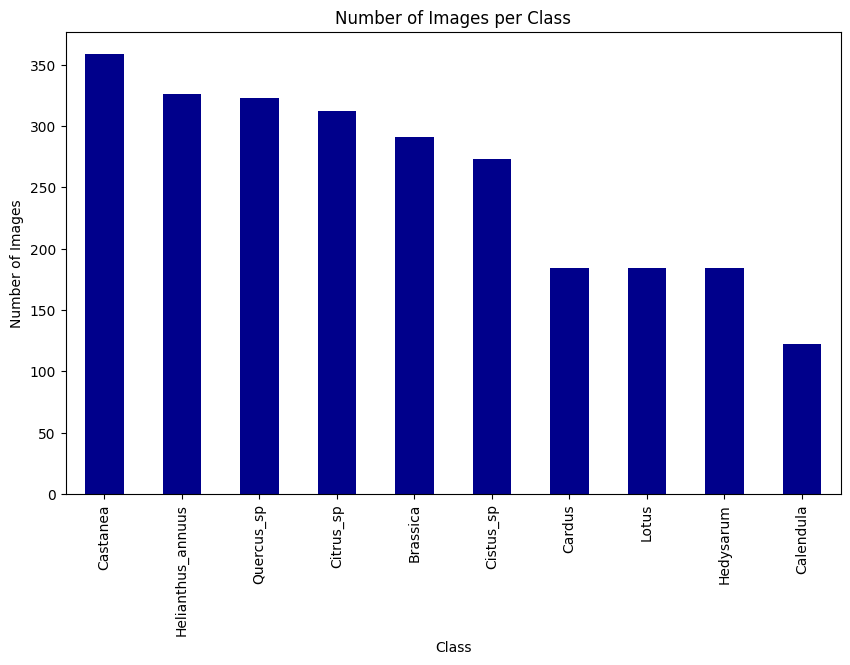

In [ ]:
#Distribution of images per class in the dataset
class_counts = ds['labels'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='darkblue')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
# Create a train_gen,  a valid_gen and a test_gen
img_size=(224,224)
batch_size=32
ds_datagen = ImageDataGenerator(rescale=1./255)

#Data augmentation
#train_datagen = ImageDataGenerator(rescale=1./255,
#                                   horizontal_flip=True,
#                                   rotation_range=20,
#                                   width_shift_range=.2,
#                                   height_shift_range=.2,
#                                   zoom_range=.2)

train_generator = ds_datagen.flow_from_dataframe(
    train_ds,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

val_generator = ds_datagen.flow_from_dataframe(
    val_ds,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size)

test_generator = ds_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col=None,
    target_size=img_size,
    class_mode=None,  # Set to None since you don't have annotations
    shuffle=False  # Set to False to maintain the order of predictions
)


Found 2046 validated image filenames belonging to 10 classes.
Found 512 validated image filenames belonging to 10 classes.
Found 635 validated image filenames.


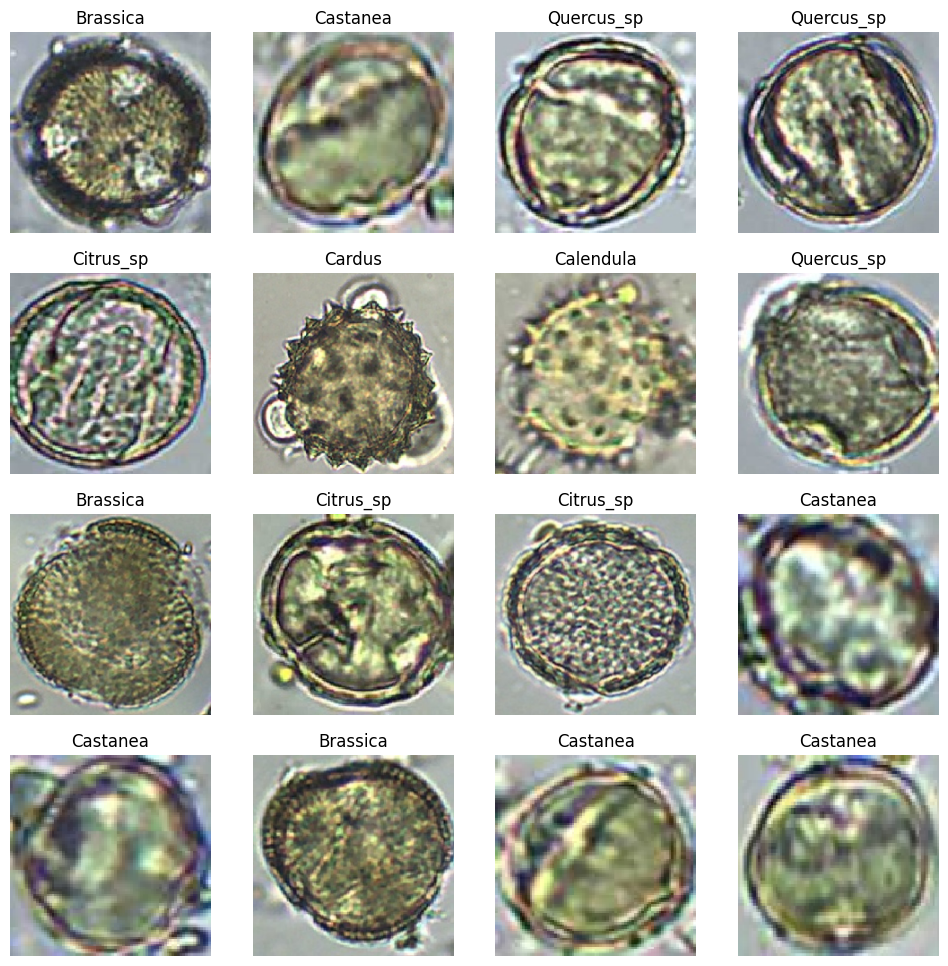

In [ ]:
# Visualize a few images from the training set
train_files=train_generator.filenames
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
labels=train_generator.labels
images, labels=next(train_generator)

plt.figure(figsize=(12, 12))

for i in range (16):
    plt.subplot(4, 4, i+1)
    index=np.argmax(labels[i])
    class_name=classes[index]
    # plt.title(class_name, color='yellow', fontsize=18)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2), # dropout for regularization
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax'),
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])
#tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

Epoch 1/14
64/64 [==============================] - 23s 156ms/step - loss: 2.2186 - accuracy: 0.1970 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6298 - val_loss: 2.1663 - val_accuracy: 0.3066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7580
Epoch 2/14
64/64 [==============================] - 10s 147ms/step - loss: 1.9213 - accuracy: 0.3348 - precision: 0.8136 - recall: 0.0469 - auc: 0.7623 - val_loss: 1.8989 - val_accuracy: 0.3242 - val_precision: 1.0000 - val_recall: 0.0156 - val_auc: 0.8006
Epoch 3/14
64/64 [==============================] - 10s 151ms/step - loss: 1.7054 - accuracy: 0.4296 - precision: 0.8103 - recall: 0.1461 - auc: 0.8230 - val_loss: 1.7214 - val_accuracy: 0.4492 - val_precision: 1.0000 - val_recall: 0.0801 - val_auc: 0.8343
Epoch 4/14
64/64 [==============================] - 9s 136ms/step - loss: 1.5320 - accuracy: 0.4741 - precision: 0.7932 - recall: 0.2155 - auc: 0.8617 - val_loss: 1.5620 - val_accuracy: 0.4727 - val_precision: 0.9

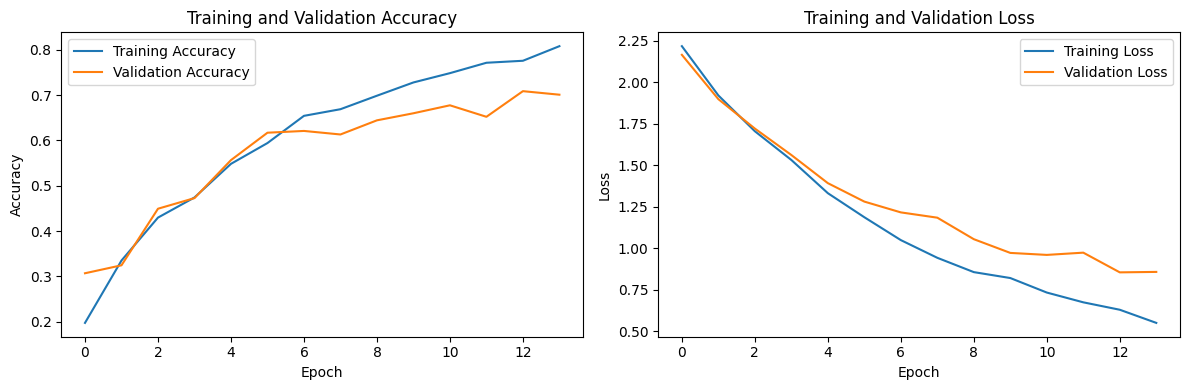

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=14,
    validation_data=val_generator,
    callbacks=tensorboard_callback)

accuracy = model.evaluate(val_generator)
print(f'The model accuracy is {accuracy[1] * 100:0.1f}%')

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
#Load tensorboard

#%tensorboard --logdir logs/fit

16/16 [==============================] - 1s 83ms/step


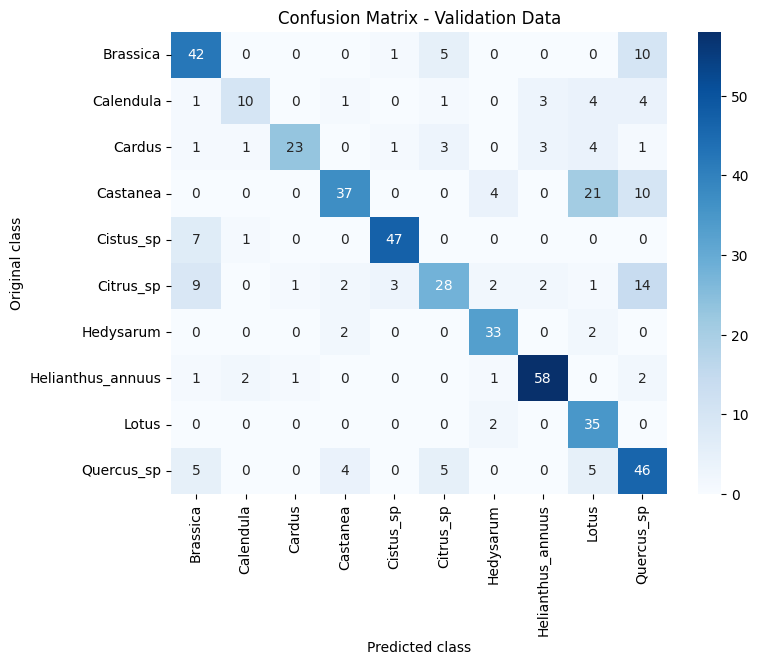

In [ ]:
# Visualize the confusion matrix for validation data
val_true_labels = val_generator.classes
val_predicted_probs = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predicted_probs, axis=1)

# Create the confusion matrix for validation data
conf_mat_val = confusion_matrix(val_true_labels, val_predicted_labels)

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_val, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted class')
plt.ylabel('Original class')
plt.show()

20/20 [==============================] - 113s 6s/step


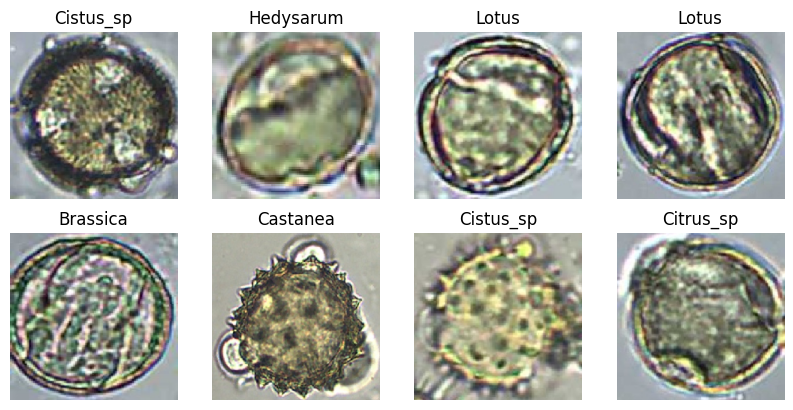

Predictions written to /content/drive/MyDrive/predictions_cnn.txt


In [ ]:
#Make predictions with the test data
predictions = model.predict(test_generator)

#Plot predictions
images = test_generator.next()
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    predicted_class_index = np.argmax(predictions[i])
    predicted_class_name = class_names[predicted_class_index]
    plt.title(predicted_class_name)
    plt.axis('off')

plt.show()

output_file = '/content/drive/MyDrive/predictions_cnn.txt'

#Save predictions to .txt file
with open(output_file, 'w') as file:
    for file_path, prediction in zip(test_filepaths, predictions):
        file_name = os.path.basename(file_path)
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        file.write(f'{file_name},{predicted_class_name}\n')

print(f'Predictions written to {output_file}')



In [ ]:
#Save the model
import time
t = time.time()

export_path = "/content/drive/MyDrive/Colab Notebooks/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

# reloaded = tf.keras.models.load_model(export_path)
# result_batch = model.predict(test_generator)
# reloaded_result_batch = reloaded.predict(test_generatorch)
# abs(reloaded_result_batch - result_batch).max()

# reloaded_predicted_id = np.argmax(reloaded_result_batch, axis=-1)
# reloaded_predicted_label_batch = [classNames[i] for i in reloaded_predicted_id]

# print(reloaded_predicted_label_batch)

# num_images = 30  # Number of images to plot
# num_cols = 5  # Number of columns in the subplot grid
# num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows

# plt.figure(figsize=(12,12))
# # Iterate over the first 30 elements in the test dataset and plot images with predictions
# for i, (image, prediction) in enumerate(zip(test_ds.take(num_images), predictions[:num_images])):
#     predicted_class_index = tf.argmax(prediction)
#     predicted_class_name = classNames[predicted_class_index.numpy()]

#     # Set up the subplot
#     plt.subplot(num_rows, num_cols, i+1)

#     # Display the image
#     plt.imshow(tf.squeeze(image))  # Assuming images are in batch format
#     plt.title(f'P. Class: {predicted_class_name}')
#     plt.axis('off')
#     _ = plt.suptitle("Model predictions")
# # Adjust layout to prevent clipping of titles
# # plt.tight_layout()
# plt.show()


'/content/drive/MyDrive/Colab Notebooks/tmp/saved_models/1700924885'